<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

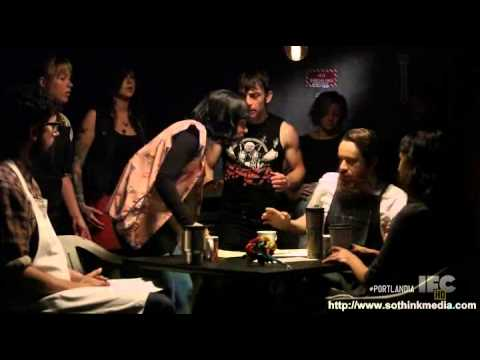

In [5]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/Users/jonathansokoll/Documents/lambda/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [173]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

df = pd.read_csv(url)
df.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [164]:
# Start here 

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [174]:
import re
import numpy as np

In [166]:
test = df.full_review_text

In [168]:
test.iloc[2862]

' 9/3/2016 25 check-ins Lovely cute little place, hands down I would say they are The best in Austin..... Hazelnut, almond custard, tiramisu, pistachio are among my favorites. '

In [175]:
# data cleaning

def seperate_dates(x):
    """Looks for #/#/#,##/##/####,##/#/#### ect
    """
    pattern = r"\s?\d+/\d+/\d+\s?"
    return re.findall(pattern,str(x))
def seperate_checkins(x):
    """looks for '# check-in'
    """
    pattern = r"\d+\scheck-in"
    return re.findall(pattern,str(x))
def clean_checkins(x):
    """if there is a check-in then seperate out the number if check-ins
    otherwise just put a 0
    """
    if len(x) == 1:
        return x[0].split()[0]
    else:
        return 0
# seperate the dates out in to own column
df["date"] = df["full_review_text"].apply(seperate_dates)
# clean the dates up take them out of list's from re matches
df["date"] = df["date"].apply(lambda x:x[0].strip())

# look for check ins
df["check_ins"] = df["full_review_text"].apply(seperate_checkins) 
# clean the check-ins up removing list's from re and grabbing that number
df["check_ins"] = df["check_ins"].apply(clean_checkins)

# clean up the star ratings and just leave the int
df["star_rating"] = df["star_rating"].apply(lambda x:x[:2].strip())

df["full_review_text"] = df["full_review_text"].apply(lambda x:re.sub(r"(\d\scheck-in[s]? | \s?\d+/\d+/\d+\s?)",'',str(x)))



In [176]:
df.sample(15)

,coffee_shop_name,full_review_text,star_rating,date,check_ins
5246,Genuine Joe,Nice cozy coffee shop somewhat closer to where...,4,9/23/2016,1
1911,Epoch Coffee,Cute place. Try the Mojo iced coffee... bomb.c...,4,11/20/2016,1
4170,Halcyon,"It's a nice little place, but with Austin hips...",3,2/5/2016,1
1986,Epoch Coffee,Listed in Caffeine Boost In comparison to the ...,4,3/14/2014,8
6699,Alta’s Cafe,You pay something like $6 for a quiche that's ...,2,8/5/2016,1
5181,TOMS,I love to go to check shoes and bags at Toms i...,5,8/23/2015,3
2980,Thunderbird Coffee,Listed in Hipster Coffee Shops A haiku to sum ...,2,5/15/2014,1
2190,Flat Track Coffee,A little coffee shop on the east side. Coffee...,4,5/25/2016,0
1974,Epoch Coffee,"I like this place, even though I've recently s...",4,1/31/2016,0
1781,Fat Cats Organic Coffee And Dessert,Thank you for offering Vegan and Organic treat...,5,11/10/2015,0


## w/e its better then it was

In [170]:
from spacy.tokenizer import Tokenizer
nlp = en_core_web_lg.load()
tokenizer = Tokenizer(nlp.vocab)

In [177]:
# Tokenizer Pipe

tokens = []

for doc in tokenizer.pipe(df['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

df['tokens'] = tokens

In [179]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [180]:
wc = count(df["tokens"])

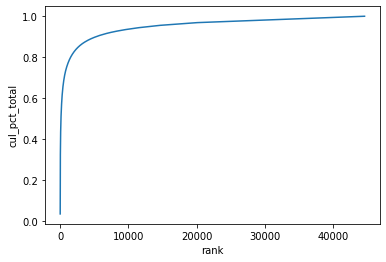

In [182]:
import seaborn as sns

# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

